# importing required libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import tensorflow as tf

# Integer labels

# importing images from folder

In [2]:
base_dir = r"D:\NeuroCure-main\NeuroCure-main\dataset"
categories = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor'] # categories
label_map = {
    'no_tumor': 0,
    'glioma_tumor': 1,
    'meningioma_tumor': 2,
    'pituitary_tumor': 3
}# dictionary for category and corresponding integer

# Function for loading images

In [3]:
def load_images(base_dir,label_map):
    images=[]
    labels=[]
    for category in categories:
        category_path=os.path.join(base_dir,category)
        label=label_map[category]

        # listing every file in perticular directory
        for filename in os.listdir(category_path):
            # check file extension
            if (filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png")):
                image_path = os.path.join(category_path,filename)
                images.append(image_path)
                labels.append(label)
    return images,labels
        
images,labels=load_images(base_dir,label_map)

# Combine shuffle and seperate

In [4]:
combined = list(zip(images, labels))
np.random.shuffle(combined)
images, labels = zip(*combined)
print(images[0])

D:\NeuroCure-main\NeuroCure-main\dataset\glioma_tumor\Tr-gl_0816.jpg


# Splitting data into train,validation and test

In [5]:
# 70% train, 30% temp
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(images, labels, test_size=0.3, stratify=labels)

# 50% of temp in each test and val
val_imgs, test_imgs, val_labels, test_labels = train_test_split(temp_imgs, temp_labels, test_size=0.5,stratify=temp_labels)

# Decoding and Preprocessing images 

In [6]:
new=tf.io.read_file(images[0])

In [7]:
new1=tf.io.decode_image(new)

In [8]:
new1.shape

TensorShape([512, 512, 1])

In [9]:
from PIL import Image
import numpy as np
import tensorflow as tf

def preprocess_image_pillow(image_path, label, training=False):
    # Open the image using Pillow
    image = Image.open(image_path).convert('RGB')  # Convert to RGB
    # Resize the image
    image = image.resize((224,224))
    # Convert the image to a numpy array
    image_array = np.array(image)
    # Normalize the image to [0, 1]
    image_array = image_array / 255.0
    # Convert the numpy array to a TensorFlow tensor
    image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32)
    # Ensure label is of correct type
    label_tensor = tf.convert_to_tensor(label, dtype=tf.int64)
    
    # Add a batch dimension
    image_tensor = tf.expand_dims(image_tensor, axis=0)

    if training:
        # Apply data augmentation
        # Random flip left-right
        image_tensor = tf.image.random_flip_left_right(image_tensor)
        # Random flip up-down
        image_tensor = tf.image.random_flip_up_down(image_tensor)
        # Random rotation (0, 90, 180, 270 degrees)
        angles = [0, 90, 180, 270]
        angle = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
        image_tensor = tf.image.rot90(image_tensor, k=angle)
        # Random brightness
        image_tensor = tf.image.random_brightness(image_tensor, max_delta=0.2)
        # Random contrast
        image_tensor = tf.image.random_contrast(image_tensor, lower=0.7, upper=1.3)
        # Random saturation
        image_tensor = tf.image.random_saturation(image_tensor, lower=0.7, upper=1.3)

    # Remove batch dimension before returning
    image_tensor = tf.squeeze(image_tensor, axis=0)

    return image_tensor, label_tensor


In [10]:
def generate_dataset(images, labels, training=False):
    for img_path, lbl in zip(images, labels):
        image_tensor, label_tensor = preprocess_image_pillow(img_path, lbl, training)
        yield image_tensor, label_tensor

def create_tf_dataset(images, labels, batch_size=32,training=False):
    dataset = tf.data.Dataset.from_generator(
        lambda: generate_dataset(images, labels, training),
        output_signature=(
            tf.TensorSpec(shape=[224,224,3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int64)
        )
    )
    dataset = dataset.batch(batch_size=batch_size)
    dataset = dataset.shuffle(buffer_size=min(len(images), 1000))
#     dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Test the dataset creation
train_data = create_tf_dataset(train_imgs, train_labels, training=True)
val_data = create_tf_dataset(val_imgs, val_labels)
test_data = create_tf_dataset(test_imgs, test_labels)


# Resnet50V2

# importing model

In [11]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense , GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Loading with weights

In [12]:

base_model = ResNet50V2(weights="imagenet",include_top=False ,input_shape=(224,224,3))

# Adding custom layers

In [13]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense,Dropout


 # Add custom layers to the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout layer
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Another Dropout layer
output = Dense(4, activation='softmax')(x)  # Output layer for 4 classes

    # Create the final model
model = Model(inputs=base_model.input, outputs=output)


# Freezing base model layers

In [14]:
for layer in base_model.layers:
    layer.trainable = False


# compiling a model

In [15]:
from tensorflow.keras.optimizers import Adam

# Training a model

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,  # Stop if no improvement for 3 epochs
    verbose=1,
    restore_best_weights=True
)

# Define model checkpoint
model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

optimizer=Adam(learning_rate=0.001)

# Define learning rate scheduler


model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',  # Use 'categorical_crossentropy' for multi-class
               metrics=['accuracy'])

# Fit the model with the callbacks
history=model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,  # Start with 30 epochs
#     steps_per_epoch=1,  # As specified
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/5


    130/Unknown 480s 2s/step - accuracy: 0.6303 - loss: 1.0885

c:\Users\saket\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 1: val_loss improved from inf to 0.49377, saving model to best_model.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 533s 2s/step - accuracy: 0.6310 - loss: 1.0862 - val_accuracy: 0.7989 - val_loss: 0.4938
Epoch 2/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7944 - loss: 0.5383
Epoch 2: val_loss improved from 0.49377 to 0.35378, saving model to best_model.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.7945 - loss: 0.5380 - val_accuracy: 0.8712 - val_loss: 0.3538
Epoch 3/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8493 - loss: 0.3936
Epoch 3: val_loss improved from 0.35378 to 0.34012, saving model to best_model.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.8493 - loss: 0.3938 - val_accuracy: 0.8780 - val_loss: 0.3401
Epoch 4/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8753 - loss: 0.3510
Epoch 4: val_loss did not improve from 0.34012
130/130 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.8752 - loss: 0.3511 - val_accuracy: 0.8

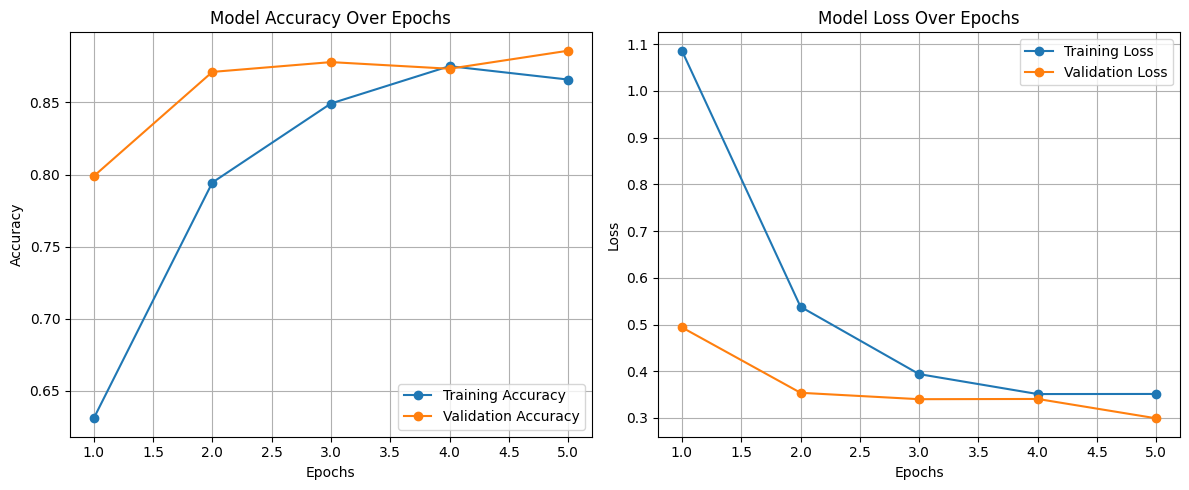

In [26]:
import matplotlib.pyplot as plt

# Data extracted from the log
epochs = range(1, 6)  # 5 epochs
accuracy = [0.6310, 0.7945, 0.8493, 0.8752, 0.8659]  # Training accuracy
val_accuracy = [0.7989, 0.8712, 0.8780, 0.8734, 0.8859]  # Validation accuracy
loss = [1.0862, 0.5380, 0.3938, 0.3511, 0.3513]  # Training loss
val_loss = [0.4938, 0.3538, 0.3401, 0.3406, 0.2991]  # Validation loss

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Display the plots
plt.tight_layout()
plt.show()


# For training on Kaggle TPU

In [17]:
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense,Dropout
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
# from tensorflow.keras.optimizers import Adam

# # Detect and initialize the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect the TPU hardware
# tf.tpu.experimental.initialize_tpu_system(tpu)  # Initialize the TPU system

# # Instantiate the TPU distribution strategy
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

# # Define the model within the TPU strategy scope
# with tpu_strategy.scope():
#     # Assuming you have a pre-trained base model (like MobileNet, EfficientNet, etc.)
#     base_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(512,512, 3))

#     # Add custom layers to the base model
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)  # Global Average Pooling
#     x = Dense(1024, activation='relu')(x)
#     x = Dropout(0.5)(x)  # Dropout layer
#     x = Dense(512, activation='relu')(x)
#     x = Dropout(0.5)(x)  # Another Dropout layer
#     output = Dense(4, activation='softmax')(x)  # Output layer for 4 classes

#     # Create the final model
#     model = Model(inputs=base_model.input, outputs=output)
    
    
#     for layer in base_model.layers:
#         layer.trainable = False
    
#     optimizer=Adam(learning_rate=0.001)


    

#     early_stopping = EarlyStopping(
#         monitor='val_loss',
#         patience=3,  # Stop if no improvement for 3 epochs
#         verbose=1,
#         restore_best_weights=True
#     )

#     # Define model checkpoint
#     model_checkpoint = ModelCheckpoint(
#         'ResNet50V2.keras',
#         monitor='val_loss',
#         save_best_only=True,
#         verbose=1
#     )
    
#     # Compile the model with optimizer, loss function, and metrics
#     model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#     # Train the model normally
#     model.fit(train_data, 
#               epochs=50,
#               validation_data=val_data, 
#               callbacks=[checkpoint_callback,early_stopping]
#     #           steps_per_epoch=1500
#              )


In [3]:
import numpy as np
import plotly.graph_objs as go
from plotly.offline import iplot

# Mock data for demonstration purposes (replace with your actual data)
y_train = np.random.choice([0, 1], size=100)  # 100 samples with classes 0 and 1
y_val = np.random.choice([0, 1], size=50)    # 50 samples with classes 0 and 1
y_test = np.random.choice([0, 1], size=30)   # 30 samples with classes 0 and 1

# Initialize the dictionary to store class counts
y = dict()
y[0] = []
y[1] = []

# Count the occurrences of each class in the datasets
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))  # Count of class '0'
    y[1].append(np.sum(set_name == 1))  # Count of class '1'

# Trace for class '0'
trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)

# Trace for class '1'
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)

# Combine the traces
data = [trace0, trace1]

# Layout for the plot
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)

# Create the figure and plot it
fig = go.Figure(data, layout)
iplot(fig)


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2

# Define the ResNet50V2 model (you can specify the input shape or other parameters)
model = ResNet50V2(weights='imagenet', input_shape=(224, 224, 3))

# Save the model
model.save("ResNet50V2.keras")


102869336/102869336 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [19]:
model.evaluate(test_data)

28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8952 - loss: 0.2837


[0.28449660539627075, 0.8939051628112793]

In [20]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import f1_score


true_labels = []
predicted_classes = []

for x_batch, y_batch in test_data:
    # Make predictions
    predictions = model.predict(x_batch)
    predicted_classes_batch = np.argmax(predictions, axis=1)
    
    # Collect true labels and predicted classes
    true_labels.extend(y_batch.numpy())
    predicted_classes.extend(predicted_classes_batch)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_classes, average='weighted')
print(f'F1 Score: {f1}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

# Loading model from last checkpoint